In [1]:
# Imports
import torch
import os 
import sys
from dask_jobqueue import SLURMCluster
from distributed import Client
from pathlib import Path

import do_simulation_drcate_discrete as file

In [2]:
# Args setup
ntrial = 100
n = 100
n_int = 2

In [3]:
# Cluster creation
cluster = SLURMCluster(
    n_workers=0,
    memory="16GB",
    processes=1,
    cores=1,
    scheduler_options={
        "dashboard_address": ":11111",
        "allowed_failures": 10
    },
    job_cpu=1,
    walltime="3:0:0",
    
    job_extra_directives = ["-p medium,fast,cpu"],
)
cluster.adapt(minimum=0, maximum=200)
client = Client(cluster)

/nfs/ghome/live/danceh/.local/mambaforge/envs/causalgp/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 11111 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42067 instead
  warnings.warn(


In [4]:
# Submitting jobs
futures = []
for seed in range(ntrial):
        f = client.submit(file.main,
                              seed,
                              n,n_int,
                              )
        futures += [f]

In [5]:
futures

[<Future: pending, key: main-23c9f4c73d0f5d40e15e6528e166c49e>,
 <Future: pending, key: main-4e3bdb7ca29427fa9342c3de40685453>,
 <Future: pending, key: main-6549af9da00a50cf38a923618a6f627d>,
 <Future: pending, key: main-1f7de92dd68d83d5b89d5a6d1e4d6513>,
 <Future: pending, key: main-078e8bb39257fee4736ab6a76d1ad850>,
 <Future: pending, key: main-574fb1d078d96d61037c08cdf700b64d>,
 <Future: pending, key: main-612e9614a8be18f2fd3341feb2f78f54>,
 <Future: pending, key: main-21077a2cf4809b91fe5f64a6da93b210>,
 <Future: pending, key: main-a09602a3f8d5fe6344a63ddb84c89c10>,
 <Future: pending, key: main-450d3889c2f1cb15e1a34c54fe59b71a>,
 <Future: pending, key: main-be0007435040a433eaaf7d97297cac65>,
 <Future: pending, key: main-41bbfd325a5805f4ff42893d8e6002e5>,
 <Future: pending, key: main-7862bf48a11f74c95344b682c56df31a>,
 <Future: pending, key: main-d340f36423ca67928c6131d77d95518d>,
 <Future: pending, key: main-e4a9d1fb944d728e451cff9130e4eb5e>,
 <Future: pending, key: main-a8eb518b214

In [6]:
# Getting results
results = client.gather(futures)

In [7]:
# Closing client
client.close()
cluster.close()

In [11]:
mean = torch.zeros(ntrial)
se = torch.zeros(ntrial)
fracs = torch.zeros((ntrial,101))
for i in range(ntrial):
    mean[i] = results[i]['post_moments'][0]
    fracs[i] =  results[i]['post_levels']

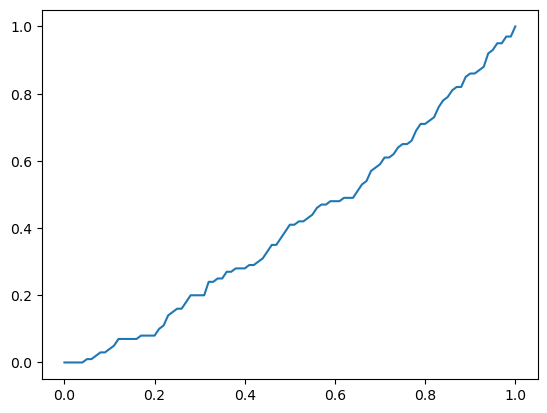

In [14]:
import matplotlib.pyplot as plt
import torch
plt.plot(torch.linspace(0,1,101),fracs.mean(0))
#plt.plot((torch.linspace(0,1,101)-fracs.mean(0)).abs())

In [17]:
fracs.mean(0)[[80,90,95]]

tensor([0.7100, 0.8600, 0.9300])

In [18]:
mean.abs().mean(),mean.abs().std()

(tensor(0.6258), tensor(0.4440))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(mean, bins = 20);

In [15]:
# Saving results
torch.save(obj = results,
           f = "simulation_dr_discrete_ntrial={0}_n={1}.pt".format(ntrial,n)
          )